In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from glob import glob

import os
from xrdc import source_separation as sep

In [2]:
plt.rcParams["figure.figsize"]=(15, 10)

In [3]:
scanfiles = sorted(glob("diffractionhistograms/diff*"), key = lambda s: int(s.split('_')[1].split('.')[0]))

In [5]:
patterns = np.vstack([(pd.read_csv(path).T)[1] for path in scanfiles])

# raw

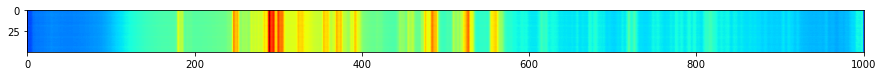

In [6]:
plt.imshow((1 + patterns), cmap = 'jet')

In [7]:
cutoff = .08

In [8]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, threshold = 25, cutoff = cutoff)

# background

In [9]:
background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, method = 'simple')

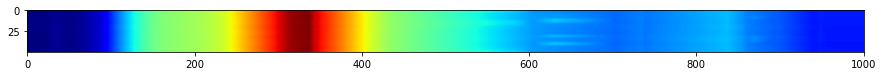

In [10]:
plt.imshow(background, cmap = 'jet')

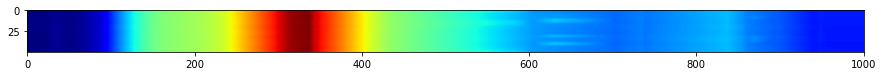

In [11]:
plt.imshow(slow_q, cmap = 'jet')

# background subtracted

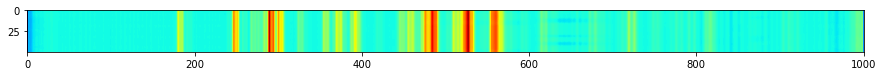

In [12]:
plt.imshow((1 + fast_q - fast_q.min()), cmap = 'jet')

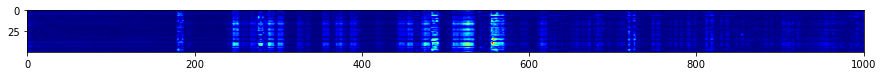

In [95]:
plt.imshow(np.log(1 + np.abs(fast_T / patterns)), cmap = 'jet')

Cutoff parameter is important!

In [152]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

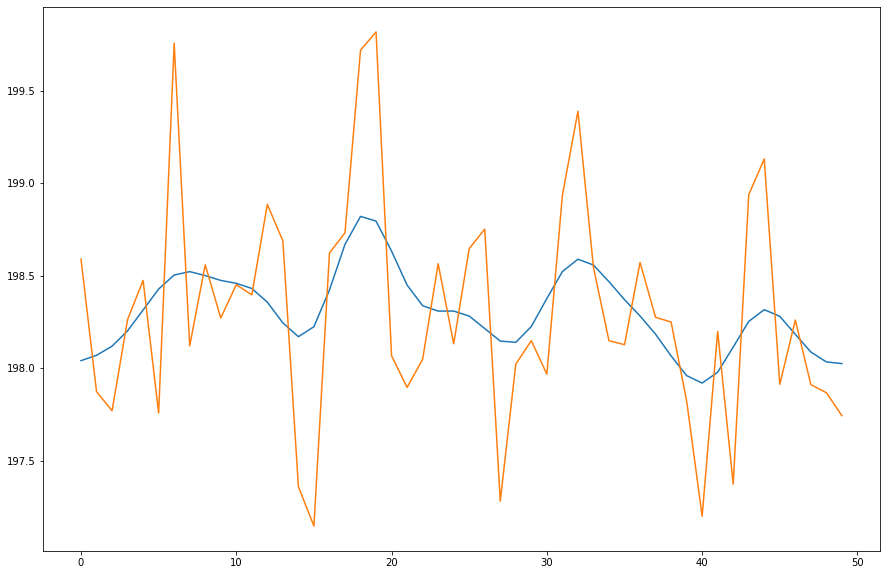

In [13]:
j = 531
plt.plot((slow_T).T[j])
plt.plot((patterns).T[j])
# plt.plot(fast_T.T[100])

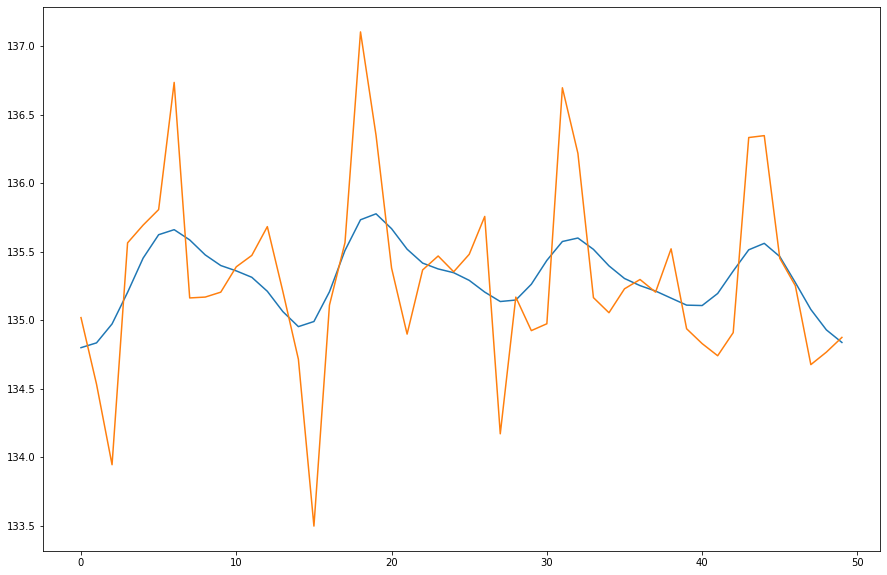

In [14]:
j = 150
plt.plot((slow_T).T[j])
plt.plot((patterns).T[j])
# plt.plot(fast_T.T[100])

In [10]:
%matplotlib notebook

In [15]:
from importlib import reload
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [16]:
%matplotlib inline
sep.iplot_rows(patterns, slow_q, fast_q, label1 = 'raw', label2 = 'background')

interactive(children=(IntSlider(value=25, description='i', max=50), Output(layout=Layout(height='550px'))), _d…

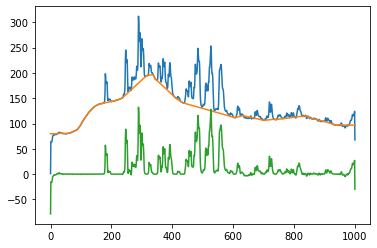

In [17]:
%matplotlib inline
i = 10
x = np.arange(len(patterns[i]))
plt.plot(x, patterns[i])
#plt.plot(background[0])
plt.plot(x, slow_q[i])
plt.plot(x, fast_q[i])

In [18]:
def peakratio(arr, xmin1, xmax1, xmin2, xmax2):
    return arr[xmin2: xmax2].sum() / arr[xmin1: xmax1].sum()

from sklearn.utils import resample

def boot(ratios, N = 200):
    boot = np.array( [resample(ratios, replace = True).mean() for _ in range(N)])
    return boot.mean(), boot.std(), boot.std() / boot.mean()

def boot_std(arr, N = 200):
    return boot(arr, N)[1]

Define peak boundaries for sample species concentration ratio calculation:

In [19]:
a, b, c, d = 318, 343, 703, 739

In [20]:
%matplotlib inline

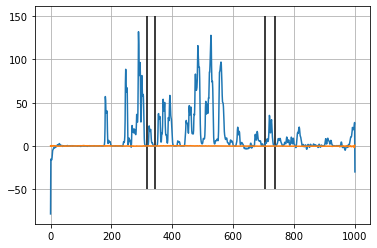

In [21]:
plt.plot(fast_q[i])
plt.plot(fast_T[i])
plt.vlines([a, b, c, d], -50, 150, color = 'k')
plt.grid()

## Peak ratio stats with bootstrapping

In [22]:
ratios = np.array([peakratio(row, a, b, c, d) for row in fast_q])
boot_ratio, boot_ratio_std, boot_ratio_std_rel = boot(ratios)
print("peak ratio (bootstrap mean),", boot_ratio)
print("peak ratio error (bootstrap standard deviation of the mean):", boot_ratio_std)
print("peak ratio relative error:", boot_ratio_std_rel)

peak ratio (bootstrap mean), 2.0787367606791416
peak ratio error (bootstrap standard deviation of the mean): 0.0017228765732420959
peak ratio relative error: 0.0008288094028217487


## Compare to no background subtraction:

In [21]:
ratios = np.array([peakratio(row, a, b, c, d) for row in patterns])
boot_ratio, boot_ratio_std, boot_ratio_std_rel = boot(ratios)
print("peak + bg ratio (bootstrap mean),", boot_ratio)
print("peak + bg ratio error (bootstrap standard deviation of the mean):", boot_ratio_std)
print("peak + bg ratio relative error:", boot_ratio_std_rel)

peak + bg ratio (bootstrap mean), 0.8280667816496476
peak + bg ratio error (bootstrap standard deviation of the mean): 0.0016762450315824648
peak + bg ratio relative error: 0.002024287254034154


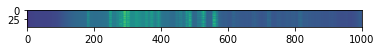

In [26]:
plt.imshow(patterns)

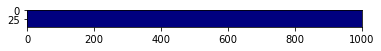

In [23]:
bgmask = sep.get_bgmask(patterns, 100, cutoff = cutoff)
plt.imshow(bgmask, cmap = 'jet')

In [40]:
fast_T.shape

(50, 1001)

In [41]:
patterns.shape

(50, 1001)

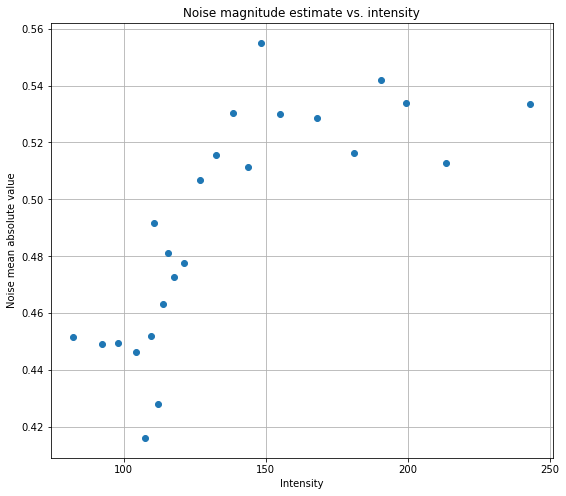

In [50]:
%matplotlib inline

nsplit = 25
fast_T_trunc = fast_T[:, 50: -50]
#intensities = (patterns * bgmask)[:, 50: -50].ravel()
intensities = patterns.ravel()

# intensities = patterns[:20, 50:400].ravel()
# intensities = slow_T.T[:20, 50:400].ravel()
# intensities = slow_T.T.ravel()

# absolute deviation
#noise = np.abs(fast_T_trunc.ravel())
# noise = fast_T.T[:20, 50:400].ravel()
noise = fast_T.ravel()

sorter = np.argsort(intensities)

splitsort = np.split(sorter, nsplit)
splitintensity = np.array([(intensities[idxs]).ravel().mean() for idxs in splitsort])

# mean absolute values of the high-T noise
splitmean = np.array([(noise[idxs]).mean() for idxs in splitsort])
split_noise_abs_std = np.array([(noise[idxs]).std() for idxs in splitsort])

#splitstd = np.array([(fast_T_trunc.ravel())[idxs].std() for idxs in splitsort])

# logsplitintensity, logsplitstd = np.log10(splitintensity), np.log10(splitstd)

plt.rcParams["figure.figsize"]=(9, 8)
plt.plot(splitintensity[splitintensity > 0][1:], splitstd[splitintensity > 0][1:], 'o')

# # plt.semilogx()
# # plt.semilogy()
plt.xlabel('Intensity')
plt.ylabel('Noise mean absolute value')
plt.title("Noise magnitude estimate vs. intensity")
matplotlib.rcParams.update({'font.size': 24})

plt.grid()

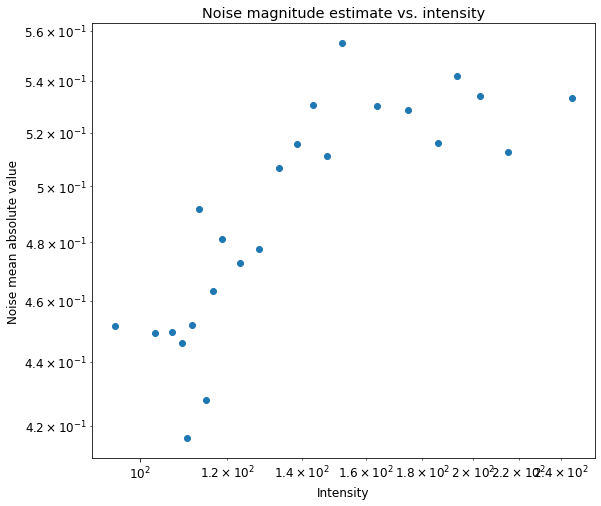

In [28]:
plt.plot(splitintensity[splitintensity > 0][1:], splitstd[splitintensity > 0][1:], 'o')

plt.semilogx()
plt.semilogy()
plt.xlabel('Intensity')
plt.ylabel('Noise mean absolute value')
plt.title("Noise magnitude estimate vs. intensity")
matplotlib.rcParams.update({'font.size': 10})

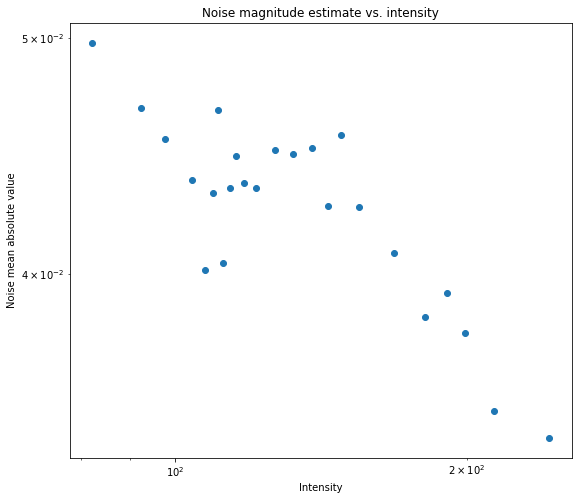

In [55]:
plt.plot(splitintensity[splitintensity > 0][1:],
         splitstd[splitintensity > 0][1:] / np.sqrt(splitintensity[splitintensity > 0][1:]), 'o')

plt.semilogx()
plt.semilogy()
plt.xlabel('Intensity')
plt.ylabel('Noise mean absolute value')
plt.title("Noise magnitude estimate vs. intensity")
matplotlib.rcParams.update({'font.size': 10})

In [51]:
arr = np.abs(noise)
aggregator = lambda arr, f: np.array([(f(arr[idxs]).ravel()) for idxs in splitsort])
medians = aggregator(arr, np.median)

p25 = aggregator(arr, lambda a: np.percentile(a, 25)).ravel()
p75 = aggregator(arr, lambda a: np.percentile(a, 75)).ravel()

yerr_above = p75 - medians
yerr_below = medians - p25

ysplits = aggregator(arr, lambda a: a)

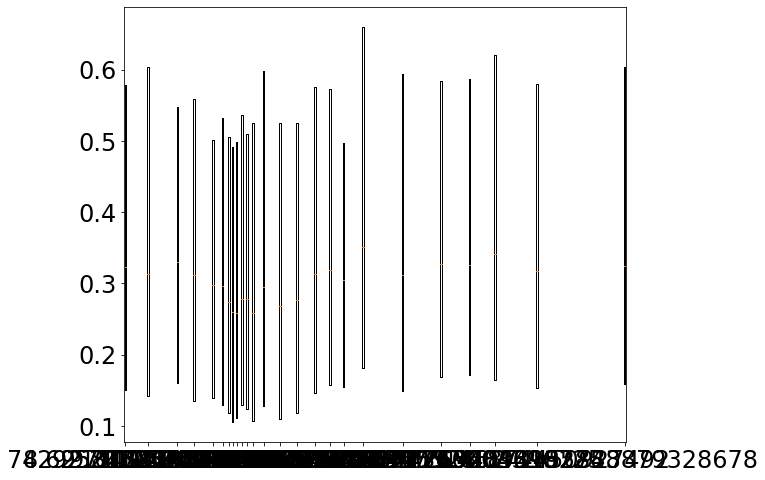

In [52]:
plt.boxplot(list(ysplits), showfliers = False, whis = 0, positions = splitintensity);